<a href="https://colab.research.google.com/github/2813/ODS-homework/blob/main/ODS_NLP_Text_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os

import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

In [34]:
import nltk
nltk.download('punkt_tab')  # раскомментируйте при первом запуске
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
!pip install gdown==4.5.4

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [5]:
# скачиваем файлы train.txt и test.txt
!gdown 1X7ezp7FAjtzpwueuyLXNjuukfI6dkhWp
!gdown 1pFm30rf5TOheLA3lFEeex8fmaSZti2L2
!gdown 1JVKnzERZ9TWjiov2Xv0jGT4bXHdum5Rg #submission.csv

Downloading...
From: https://drive.google.com/uc?id=1X7ezp7FAjtzpwueuyLXNjuukfI6dkhWp
To: /content/train.csv
100% 11.3M/11.3M [00:00<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pFm30rf5TOheLA3lFEeex8fmaSZti2L2
To: /content/test.csv
100% 2.85M/2.85M [00:00<00:00, 24.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JVKnzERZ9TWjiov2Xv0jGT4bXHdum5Rg
To: /content/sample_submission.csv
100% 86.2k/86.2k [00:00<00:00, 62.3MB/s]


In [6]:
train_data = pd.read_csv(os.path.join("", "train.csv"))
test_data = pd.read_csv(os.path.join("", "test.csv"))

In [42]:
test_data

,index,text
0,0,Очень хороший магазин и сотрудники приятный
1,1,"Самый обычный продуктовый магазин. Есть сыры,..."
2,2,Всё хорошо и комфортно
3,3,"Маленький филиальчик, все необходимое есть. Дв..."
4,4,Плохо относятся к клиентам!!!!!\n
...,...,...
12162,12162,Персонал вежливый . Большой ассортимент
12163,12163,Скидки на сыры. Скидки на алкоголь. Приемлимые...
12164,12164,"Рядом с домом, неплохая пятерочка, персонал хо..."
12165,12165,Хороший магазин у дома. Кассиры приветливые. П...


In [7]:
# невалидные данные для обучения, например с перепутанным рейтингом:
# "удобный магазин, все отлично" -- 1 звезда

#
# отфильтровали по положительным словам (отлично, великолепно и тд), у которых рейтинг 1
# аналогично для отрицательных слов (отвратительно, грязно и тд), у которых рейтинг 5
#
suspicious_idx_checked = [
    42691, 34774, 17428, 14352, 14109, 13634, 13694, 549, 48056, 45274, 45418,
    41957, 39378, 37982, 33056, 32318, 26932, 22037, 20608, 670, 8060, 41957,
    2061, 2027, 6719, 9048, 9010, 9280, 21639, 21333, 47484, 41845, 33172, 29964, 8653, # 5
    40479, 1210, 2691, 3459, 3934, 6593, 21353, 19933, 1206, 1210, 23390, 22037,
    29057, 25252, 21353, 37982, 44599, 2691, 15012, 22037, 23597, 36337, 38046,
    29030, 20936, 33172, 32938, 35763, 38079, 37353, 45629, 46484, 41165, 107, 106
]

train_data = train_data.drop(suspicious_idx_checked)

In [8]:


# Заменяем "Не плохо" на "неплохо"
#
#
train_data['text'] = train_data['text'].apply(
    lambda x: re.sub(r'(^|\s|[,:\.])не\sплох($|(ой|ая|ое|ие|о|а|их|ую|о)|\s|[,\.!\?])', r'\1неплох\2', x, flags=re.IGNORECASE) if isinstance(x, str) else x
)

In [9]:
# вставляем пробелы после запятыми, чтобы корректней определять слова
train_data['text'] = train_data['text'].apply(
    lambda x: re.sub(r',(\S)', r', \1', str(x))
)

In [10]:
# Определяем все отзывы состоящии из одного слова.
single_word_mask = train_data['text'].apply(lambda x: len(str(x).split()) == 1)
single_word_rows = train_data[single_word_mask]
# Удаляем все отзывы состоящие из одного предложения
train_data = train_data[~single_word_mask]

In [12]:
back_translated_data1 = pd.read_csv(os.path.join("", "final_data1.csv"))
back_translated_data2 = pd.read_csv(os.path.join("", "final_data2.csv"))
back_translated = pd.concat([back_translated_data1, back_translated_data2], axis=0)

In [187]:
back_translated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 0 to 62
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    138 non-null    int64 
 1   text    138 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [3]:
# В Colab выполните:
from google.colab import _message

# Перезагружает ноутбук
_message.blocking_request('reload_extension', request='', timeout_sec=5)

{'error': {'type': 'NO_HANDLER_ERROR',
  'description': 'No handler was provided for the given request type: reload_extension'}}

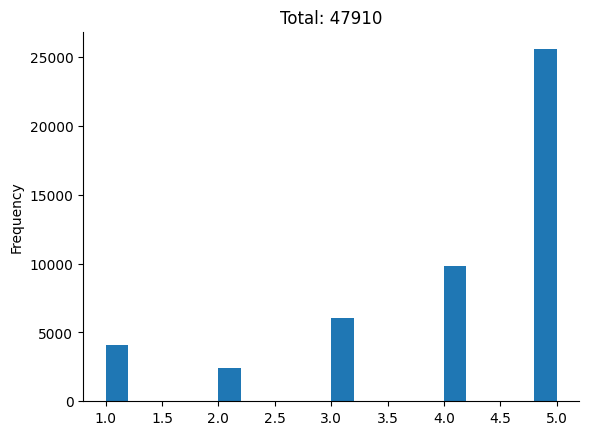

In [29]:
from matplotlib import pyplot as plt
train_data['rate'].plot(kind='hist', bins=20, title=f'Total: {len(train_data)}')
plt.gca().spines[['top', 'right',]].set_visible(False)


In [13]:
import pandas as pd
import random
from tqdm import tqdm

def shuffle_first_five_words(text):
    """
    Перемешивает первые 5 слов в тексте
    Если слов меньше 5, перемешивает все доступные слова
    """
    if not isinstance(text, str):
        return text

    # Разбиваем текст на слова
    words = text.split()

    # Если слов меньше 2, возвращаем оригинал (нечего перемешивать)
    if len(words) < 2:
        return text

    # Определяем сколько слов будем перемешивать
    n_words_to_shuffle = min(5, len(words))

    # Отделяем слова для перемешивания и остальные
    words_to_shuffle = words[:n_words_to_shuffle]
    rest = words[n_words_to_shuffle:]

    # Перемешиваем слова
    random.shuffle(words_to_shuffle)

    # Собираем обратно
    shuffled_text = ' '.join(words_to_shuffle + rest)
    return shuffled_text

# Применяем функцию ко всем текстам с прогресс-баром
tqdm.pandas()
filtered_data = train_data[train_data['rate'] < 5].copy()
filtered_data.loc[:, 'text'] = filtered_data['text'].progress_apply(shuffle_first_five_words)

print("Обработка завершена!")

100%|██████████| 22354/22354 [00:00<00:00, 146491.39it/s]

Обработка завершена!


In [31]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22354 entries, 0 to 48664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    22354 non-null  int64 
 1   text    22354 non-null  object
dtypes: int64(1), object(1)
memory usage: 523.9+ KB


NameError: name 'plt' is not defined

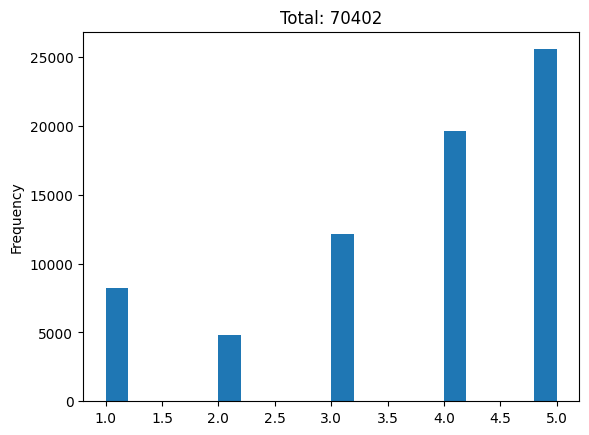

In [14]:
train_data = pd.concat([train_data, filtered_data, back_translated], axis=0)
train_data['rate'].plot(kind='hist', bins=20, title=f'Total: {len(train_data)}')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [56]:
from transformers import pipeline

classifier = pipeline("text-classification", model = "sberbank-ai/ruRoberta-large")



config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [57]:
classifier("Одно из многих, но одна из хуших, ценники не меняются и даже не хотят начинать это делать, просрочка, отношение такое как будто ты ещё им должен после этого! Данный магазин обходите стороной")
## [{'label': '1 star', 'score': 0.3701983392238617}]

[{'label': 'LABEL_0', 'score': 0.638813316822052}]

In [48]:
test_data.shape

(12167, 2)

In [50]:
data = test_data[0:200].copy()
data['rate'] = [stars_to_rating(classifier(text)[0]['label']) for text in data.text]

In [47]:
data

,index,text,rate
0,0,Очень хороший магазин и сотрудники приятный,5
1,1,"Самый обычный продуктовый магазин. Есть сыры,...",5
2,2,Всё хорошо и комфортно,5
3,3,"Маленький филиальчик, все необходимое есть. Дв...",4
4,4,Плохо относятся к клиентам!!!!!\n,1
...,...,...,...
95,95,Выбора товаров много\nПерсонал вежливый\nРаспо...,4
96,96,"Средних размеров стандартная пятёрочка, выбор ...",3
97,97,Очень скромный ассортимент,4
98,98,Самый лучший магазин. Директор тоже персонал т...,5


In [53]:
sample_submission = pd.read_csv(os.path.join("", "sample_submission.csv"))
sample_submission["rate"] = predictions
#sample_submission.rate = le.inverse_transform(sample_submission.rate)
sample_submission.head()

NameError: name 'predictions' is not defined

BASE LINE


In [14]:
import torch
from torch.utils.data import Dataset


class FiveDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['text'].tolist()
        self.targets = None
        if 'rate' in dataframe:
            self.targets = dataframe['rate'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)

In [15]:
from typing import Dict

import torch
from transformers import AutoModel


class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.pre_classifier = torch.nn.Linear(312, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.classifier(hidden_state)
        return output

In [16]:
from typing import Dict

import torch
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm


class Trainer:
    def __init__(self, config: Dict):
        self.config = config
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: Adam(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])
        return self.model.eval()

    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print(acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                predictions.extend(outputs.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

In [17]:
le = LabelEncoder()

train_data.rate = le.fit_transform(train_data.rate)
train_data.head()


,rate,text
0,3,Очень понравилось. Были в начале марта с соба...
1,4,В целом магазин устраивает.\nАссортимент позво...
2,4,"Очень хорошо что открылась 5 ка, теперь не над..."
3,2,Пятёрочка громко объявила о том как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра..."


In [18]:

train_split, val_split = train_test_split(train_data, test_size=0.15, random_state=42)

In [19]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
MAX_LEN = 128
BATCH_SIZE = 64

In [21]:
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)

In [22]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

In [23]:
config = {
    "num_classes": 5,
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [34]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 2,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config)

In [36]:
t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/2


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

0.7384717464447021
Epoch 2/2


  0%|          | 0/936 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

0.7615755796432495


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, ele

In [37]:
t.save("baseline_model2.ckpt")

In [35]:
t = Trainer.load("baseline_model2.ckpt")

In [38]:
predictions = t.predict(test_dataloader)

In [28]:
!gdown 1JVKnzERZ9TWjiov2Xv0jGT4bXHdum5Rg #submission.csv

Downloading...
From: https://drive.google.com/uc?id=1JVKnzERZ9TWjiov2Xv0jGT4bXHdum5Rg
To: /content/sample_submission.csv
100% 86.2k/86.2k [00:00<00:00, 129MB/s]


In [39]:
sample_submission = pd.read_csv(os.path.join("", "sample_submission.csv"))
sample_submission["rate"] = predictions
sample_submission.rate = le.inverse_transform(sample_submission.rate)
sample_submission.head()

,index,rate
0,0,5
1,1,3
2,2,5
3,3,5
4,4,1


In [41]:
sample_submission.to_csv("submission.csv", index=False)

In [147]:
back_translated_data1 = back_translated_data1.drop(columns=['sentence_count_nltk', 'is_augmented'])

In [177]:
back_translated_data1.to_csv('final_data1.csv', index=False, encoding='utf-8')

In [53]:
pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00


In [83]:
selected_data = train_data[
    (train_data['text'].str.len() > 1000) & (train_data['rate'] == 1)
]

In [84]:
selected_data

,rate,text,sentence_count_nltk
107,1,"Постоянно мало выбора, Разбросаны кор...",0
2743,1,Самая ужасная пятерочка во всем Пушкине (начин...,0
7459,1,"Давно туда не хожу. Даже забыл, когда там был ...",0
7615,1,"07.10.21 я посетила магазин ""Пятерочка"", таког...",0
7933,1,"Сегодня зашла с утра сюда., набрала будок и ка...",0
...,...,...,...
45598,1,06.02.2021 около 13:00 я совершала покупки в м...,0
46352,1,"Сегодня в 8 утра зашла в этот магазин, это ужа...",0
47259,1,07.09 в 15 .10 мой муж сканировал товар на кас...,0
47432,1,Если бы можно было поставить меньше - поставил...,0


In [102]:
from deep_translator import GoogleTranslator
import pandas as pd
import time
import random

class TextAugmenter:
    def __init__(self):
        self.intermediate_languages = ['fr', 'de', 'es', 'it', 'pt', 'nl']

    def back_translate(self, text, lang=None):
        """Back translation через Google Translate"""
        if lang is None:
            lang = random.choice(self.intermediate_languages)

        try:
            print(f"Аугментируем текст (через {lang})...")

            # Прямой перевод
            translator_to = GoogleTranslator(source='ru', target=lang)
            translated = translator_to.translate(text)

            # Пауза для избежания блокировки
            time.sleep(1)

            # Обратный перевод
            translator_back = GoogleTranslator(source=lang, target='ru')
            back_translated = translator_back.translate(translated)

            return back_translated

        except Exception as e:
            print(f"Ошибка при переводе через {lang}: {e}")
            return text  # Возвращаем оригинал в случае ошибки

    def augment_dataset(self, texts, samples_per_text=1):
        """Аугментация набора текстов"""
        augmented_texts = []

        for i, text in enumerate(texts):
            print(f"Обработка текста {i+1}/{len(texts)}")

            # Пропускаем слишком короткие тексты
            if len(text) < 50:
                augmented_texts.append(text)
                continue

            for j in range(samples_per_text):
                augmented = self.back_translate(text)
                augmented_texts.append(augmented)

                # Пауза между запросами
                if (i * samples_per_text + j + 1) % 5 == 0:
                    print("Пауза...")
                    time.sleep(0.5)

        return augmented_texts

# Использование
augmenter = TextAugmenter()

# Ваши отфильтрованные данные
selected_data = train_data[
    (train_data['text'].str.len() > 1000) &
    (train_data['rate'].isin([2, 3, 4]))
]

texts_to_augment = selected_data['text'].tolist()

print(f"Найдено текстов для аугментации: {len(texts_to_augment)}")

# Аугментируем тексты
augmented_texts = augmenter.augment_dataset(texts_to_augment, samples_per_text=1)

# Создаем новый DataFrame
augmented_df = selected_data.copy()
augmented_df['text'] = augmented_texts
augmented_df['is_augmented'] = True

# Объединяем с оригинальными данными
final_data = pd.concat([train_data, augmented_df], ignore_index=True)

print(f"Итоговый размер датасета: {len(final_data)}")

Найдено текстов для аугментации: 64
Обработка текста 1/64
Аугментируем текст (через pt)...
Обработка текста 2/64
Аугментируем текст (через es)...
Обработка текста 3/64
Аугментируем текст (через pt)...
Обработка текста 4/64
Аугментируем текст (через de)...
Обработка текста 5/64
Аугментируем текст (через fr)...
Пауза...
Обработка текста 6/64
Аугментируем текст (через fr)...
Обработка текста 7/64
Аугментируем текст (через es)...
Обработка текста 8/64
Аугментируем текст (через pt)...
Обработка текста 9/64
Аугментируем текст (через pt)...
Обработка текста 10/64
Аугментируем текст (через es)...
Пауза...
Обработка текста 11/64
Аугментируем текст (через it)...
Обработка текста 12/64
Аугментируем текст (через de)...
Обработка текста 13/64
Аугментируем текст (через es)...
Обработка текста 14/64
Аугментируем текст (через pt)...
Обработка текста 15/64
Аугментируем текст (через es)...
Пауза...
Обработка текста 16/64
Аугментируем текст (через fr)...
Обработка текста 17/64
Аугментируем текст (через p

In [103]:
augmented_df

,rate,text,sentence_count_nltk,is_augmented
2055,2,Есть 2 А - до ремонта этим летом и после ремон...,0,True
2167,3,"Магазин в целом неплохой, места много, не прих...",0,True
2406,3,Именно это и сделал закон об отмене бумажных ч...,0,True
2635,4,"Если вы ищете описание ассортимента, список ск...",0,True
2924,3,"Говорят, что качество обслуживания в сетевых м...",0,True
...,...,...,...,...
46781,4,"Читал не один раз, не лесной отзыв об этой тор...",0,True
46786,4,После более чем 10 лет общения с этим магазино...,0,True
47632,3,Старые сотрудники стараются. Водители меняются...,0,True
48064,4,They often forget to change the price tags. Ес...,0,True


In [165]:
filtered_data.tail()

,rate,text
48654,4,от зависит директора. Пятёрочка... Магазин
48656,4,"хуже и не лучше Не других, но персонал приветл..."
48661,2,"написанна Постоянно обман в цене, сумма на акц..."
48662,2,магазину хочется пожелать этому Очень стать та...
48664,3,персонал очень Не


In [120]:
train_data.tail()

,rate,text,sentence_count_nltk,text_shuffled
48660,5,"Удобный, но маленький и ещё не обновили как др...",0,"Удобный, ещё но и маленький не обновили как др..."
48661,2,"Постоянно обман в цене, написанна сумма на акц...",0,"написанна в цене, обман Постоянно сумма на акц..."
48662,2,Очень хочется пожелать этому магазину стать та...,0,Очень пожелать этому магазину хочется стать та...
48663,5,"Нравится ваш магазин, персонал одекватный, пор...",0,"Нравится персонал магазин, ваш одекватный, пор..."
48664,3,Не очень персонал,0,Не очень персонал


In [105]:
augmented_df.to_csv('final_data2.csv', index=False, encoding='utf-8')

In [85]:
from deep_translator import GoogleTranslator
import time

# Ваш исходный текст
original_text = train_data["text"][305]

# Инициализируем переводчики
# Можно использовать и YandexTranslator
translator_to_fr = GoogleTranslator(source='ru', target='fr')
translator_back_to_ru = GoogleTranslator(source='fr', target='ru')

def back_translate(text, intermediate_lang='fr', verbose=False):
    """Функция для разворота перевода"""
    try:
        # Шаг 1: Переводим на язык-посредник (напр., французский)
        translated = translator_to_fr.translate(text)
        if verbose: print(f"На французский: {translated}")

        # Небольшая задержка, чтобы не превысить лимиты API
        time.sleep(0.5)

        # Шаг 2: Переводим обратно на русский
        back_translated = translator_back_to_ru.translate(translated)
        if verbose: print(f"Обратно на русский: {back_translated}")

        return back_translated

    except Exception as e:
        print(f"Ошибка: {e}")
        return None

# Применяем аугментацию

#aug_train_data = train_data.query("rate == 1")

aug_train_data = selected_data.apply(
    lambda x: back_translate(x)
)

#augmented_text = back_translate(original_text)

print("\n--- Результат ---")
#print(f"Оригинал: {original_text}")
#print(f"Аугменти: {augmented_text}")

Ошибка: 107      1
2743     1
7459     1
7615     1
7933     1
        ..
45598    1
46352    1
47259    1
47432    1
48421    1
Name: rate, Length: 76, dtype: int64 --> text must be a valid text with maximum 5000 character,otherwise it cannot be translated
Ошибка: 107      Постоянно мало выбора,          Разбросаны кор...
2743     Самая ужасная пятерочка во всем Пушкине (начин...
7459     Давно туда не хожу. Даже забыл, когда там был ...
7615     07.10.21 я посетила магазин "Пятерочка", таког...
7933     Сегодня зашла с утра сюда., набрала будок и ка...
                               ...                        
45598    06.02.2021 около 13:00 я совершала покупки в м...
46352    Сегодня в 8 утра зашла в этот магазин, это ужа...
47259    07.09 в 15 .10 мой муж сканировал товар на кас...
47432    Если бы можно было поставить меньше - поставил...
48421    Здравствуйте!  (24 мая 2021 года), в районе 21...
Name: text, Length: 76, dtype: object --> text must be a valid text with maximum 5000

In [89]:
aug_train_data

,0
rate,None
text,None
sentence_count_nltk,None


In [87]:
len(train_data["text"][2743])

1216

In [88]:
row = 7459
print(train_data["text"][row])
back_translate(train_data["text"][row])

Давно туда не хожу. Даже забыл, когда там был в последний раз. Странно у них там как - то. Берëшь товар по акции, или красной цене, а на кассе обнаруживаешь, о - го! - дерут за просрочку по полной! Или вот, брал продукты, в их магазине в Сосново, под Приозерском. Ромовую бабу взял, а мне на кассе говорит продавец, "берите две, у нас распродажа, и будет по цене одной ". Я взял, а когда в доме посмотрел чек, там пробито две! То есть, меня там нагло обманули! Я не стал возвращаться туда. Зачем мелочиться? Просто, для себя отправил в бан эту точку их сети! И написал по этой теме отзыв! Рад, что могу повторить. Пусть честной народ знает, кто и как торгует! В их магазине в Келозях, нечто похожее, когда проверяешь цену на ценнике, поднося штрих - код к устройству, а там либо несоответствие, либо выявляешь это несоответствие уже по чеку на кассе, когда разбираешь пакет дома. У них там на поток это разводилово поставлено. Поэтому, куда - куда, но только не в пятëрочку! 
Если меня кто спрашивает

'Я давно там не был. Я даже забыл, когда был там в последний раз. Странно, как они там это делают. Вы покупаете товар по акционной цене, или по красной цене, а на кассе обнаруживаете, ух! - они заставляют вас платить за задержку! Или я делал покупки в их магазине в Сосново, под Приозерском. Я взяла ромовую бабу, а на кассе продавец мне сказал: «бери две, у нас распродажа, и она будет по цене одной». Я взяла, а когда посмотрела чек, в доме было два прокола! Другими словами, меня там явно обманули! Я не вернулся туда. Зачем тратить время на мелочи? Я просто забанил для себя этот пункт из их сети! И я написал об этом отзыв! Рад, что могу это повторить. Пусть честные люди знают, кто и как торгует! В их магазине Kelozy нечто похожее, когда проверяешь цену на ценнике, удерживая штрих-код на устройстве, и либо есть несоответствие, либо выявляешь это несоответствие по чеку на кассе, когда сортируешь посылку дома. Они разместили это там как часть мошенничества. Так куда-где, только не в пятёрку